In [13]:
from IPython.display import display
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

In [2]:
model_nm = 'sentence-transformers/all-MiniLM-L6-v2'

In [19]:
sentences = ['I am fine.', 'How are you?']

In [20]:
#Load tokensier and model from Huggingface Hub
tokenizer = AutoTokenizer.from_pretrained(model_nm)
model = AutoModel.from_pretrained(model_nm)

In [21]:
#Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

In [22]:
#Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

In [23]:
# Mean pooling - Take the attention into account for correct averaging
token_embeddings = model_output[0] # First element of model_output contains all the token embeddings

In [24]:
input_mask_expanded = encoded_input['attention_mask'].unsqueeze(-1).expand(token_embeddings.size()).float()

In [25]:
#Perform Pooling
sentence_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)/ torch.clamp(input_mask_expanded.sum(1), min = 1e-9)

In [26]:
#Normalize embeddings
#sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim =1)

In [27]:
print('Sentence Embeddings')
print(sentence_embeddings)

Sentence Embeddings
tensor([[-8.6994e-02, -5.1852e-01,  7.5593e-02,  1.4929e-02,  1.4677e-01,
         -4.9090e-02,  3.3937e-01,  1.5029e-02, -6.6144e-01, -1.7550e-01,
         -2.0103e-01,  5.2617e-02, -1.4510e-01,  9.1951e-03,  1.2597e-01,
          1.2854e-01,  3.7786e-01, -5.3831e-01, -5.3632e-01,  5.7287e-01,
         -3.2727e-01,  5.1169e-01,  3.9818e-02,  2.3520e-01, -6.2170e-01,
         -1.4634e-01, -2.7377e-01, -3.8993e-01,  1.7295e-01, -9.1103e-02,
         -6.6376e-01,  2.8345e-01,  2.1761e-01, -4.3573e-01, -4.2731e-01,
          2.6554e-01, -9.8852e-02, -5.4628e-01,  4.3405e-01,  1.9277e-01,
         -1.1773e-01,  2.6267e-02, -9.4900e-02,  3.1015e-01,  3.3335e-01,
         -2.9942e-01, -1.1638e-02, -3.1121e-02,  4.3455e-01, -9.5597e-02,
         -2.1750e-01,  2.4191e-01, -3.9400e-01,  4.4179e-01,  4.7030e-01,
          1.0415e-01,  5.4627e-03, -1.1989e-01,  3.0431e-01,  9.1419e-02,
         -9.4281e-02,  5.8772e-02, -8.1379e-03,  4.5068e-01,  3.1200e-01,
         -1.2631e-

Let's generate an embedding for a sentence such as "I am fine".

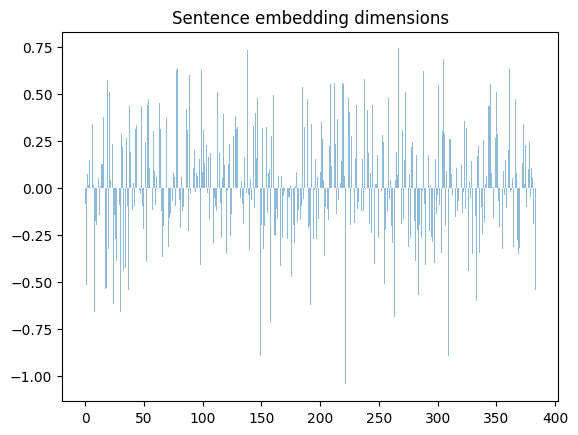

In [28]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt; plt.rcdefaults()
# visualize it in a barchart to show the range of values in the 384 dimensions
y_pos = np.arange(len(sentence_embeddings[0])) 
plt.bar(y_pos, sentence_embeddings[0], align='center', alpha=0.5)
plt.title('Sentence embedding dimensions')
plt.show()

Looking at the output alone, it's rather difficult to evaluate the embedding. Next, let’s make some manual changes to this original sentence so that we can create a list of sentences with a clear range of similarity.

What if we change one word slightly, or change the ordering or the form of the question? Do we notice certain dimensions changing or does it appear random? 

Is is like word embeddings and we can see some pattern that seems to correspond to minor changes compared with larger changes?
The table below shows the sentences we will look at together:


No	Difference	Sentence
1	Original sentence	How can I reset my password
2	Plural word	How can I reset my passwords
3	Remove word	How can I reset my password
4	Change order	reset can password How I my
5	Similar	How can I change my password
6	Different sentence	What is the capital of Ireland

To compare the embeddings, we will generate two embeddings. One embedding will represent the original sentence “How can I reset my password” and the other will be one of the six altered sentences in the above table. We want to see what impact the changes to the sentence have on the embeddings.

#### Comparing dimensions
If it is a small change, then we would expect the embeddings to change slightly compared to a larger change. By generating two embeddings we can look at the dimensions and see which ones changed and by how much. We can ignore minor changes and look at the dimensions that changed by 10% or more. And we can also get the average change across all dimensions.

#### Comparing similarity
In conjunction with the dimensions, we also want to see how similar the sentence embeddings appear when compared to each other visually. Since we have seen how difficult it is to “eyeball” our embedding, we need to find some other way to visually inspect it.

**You might be inclined to just go ahead and start using the embedding due to the difficulty in representing it visually. However, it is well worth spending time on playing around with the output of the model to see if you can infer anything from that. At the very least you will be more comfortable with the output itself when you do use it!**

In [33]:

def generate_embedding(sentences):
    #Tokenize sentences
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
    #Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
    # Mean pooling - Take the attention into account for correct averaging
    token_embeddings = model_output[0] # First element of model_output contains all the token embeddings
    input_mask_expanded = encoded_input['attention_mask'].unsqueeze(-1).expand(token_embeddings.size()).float()
    #Perform Pooling
    sentence_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)/ torch.clamp(input_mask_expanded.sum(1), min = 1e-9)

    return sentence_embeddings

In [34]:
# Pick a threshold which is the minimum amount of percentage change which we are looking for
limit = 10

def calc_diff(embeds):
    # Calculate the % change for each dimension
    diff = [(a - b)/a for a,b in zip(embeds[0], embeds[1])]
    # Get the positive values for each element on the list
    diff = [abs(x) for x in diff]
    value = []
    dim = []
    avgs = []
    res = {}
    for n,v in enumerate(diff):
        avgs.append(v)
        if v > limit or v < -limit:
            value.append(v)
            dim.append(n)
    avg = sum(avgs) / len(avgs)
    res["dims"] = dim
    res["avg"] = avg
    res["value"] = value
    return(res)

In [45]:
def charts(results, embeds, messages):
    plt.figure(figsize=(20, 14))
    y_pos = np.arange(len(results["dims"]))
    plt.tight_layout(pad=0.9, w_pad=0.5, h_pad=1.0)
    plt.subplot(2, 1, 1)
    p=plt.bar(y_pos, results["value"], align='center', alpha=0.5, color='black')
    plt.xticks(y_pos, results["dims"])
    plt.ylabel('Percent difference', fontsize=25)
    plt.title('Dimensions with change > %s percent' % (limit), fontsize=25)

    plt.xlabel("Dimemsions count: %s, Average change: %r" % (len(results["dims"]),  results["avg"]),
               fontsize=18)

    plt.subplot(2, 1, 2)
    plt.scatter(embeds[0], embeds[1], marker="o", c=["black"], s=25)
    plt.title('Comparing similarity', fontsize=24)
    plt.xlabel("%s - x axis \n %s - y axis" % (messages[0], messages[1]), fontsize=25, 
               color="black", wrap=True)

    plt.show()

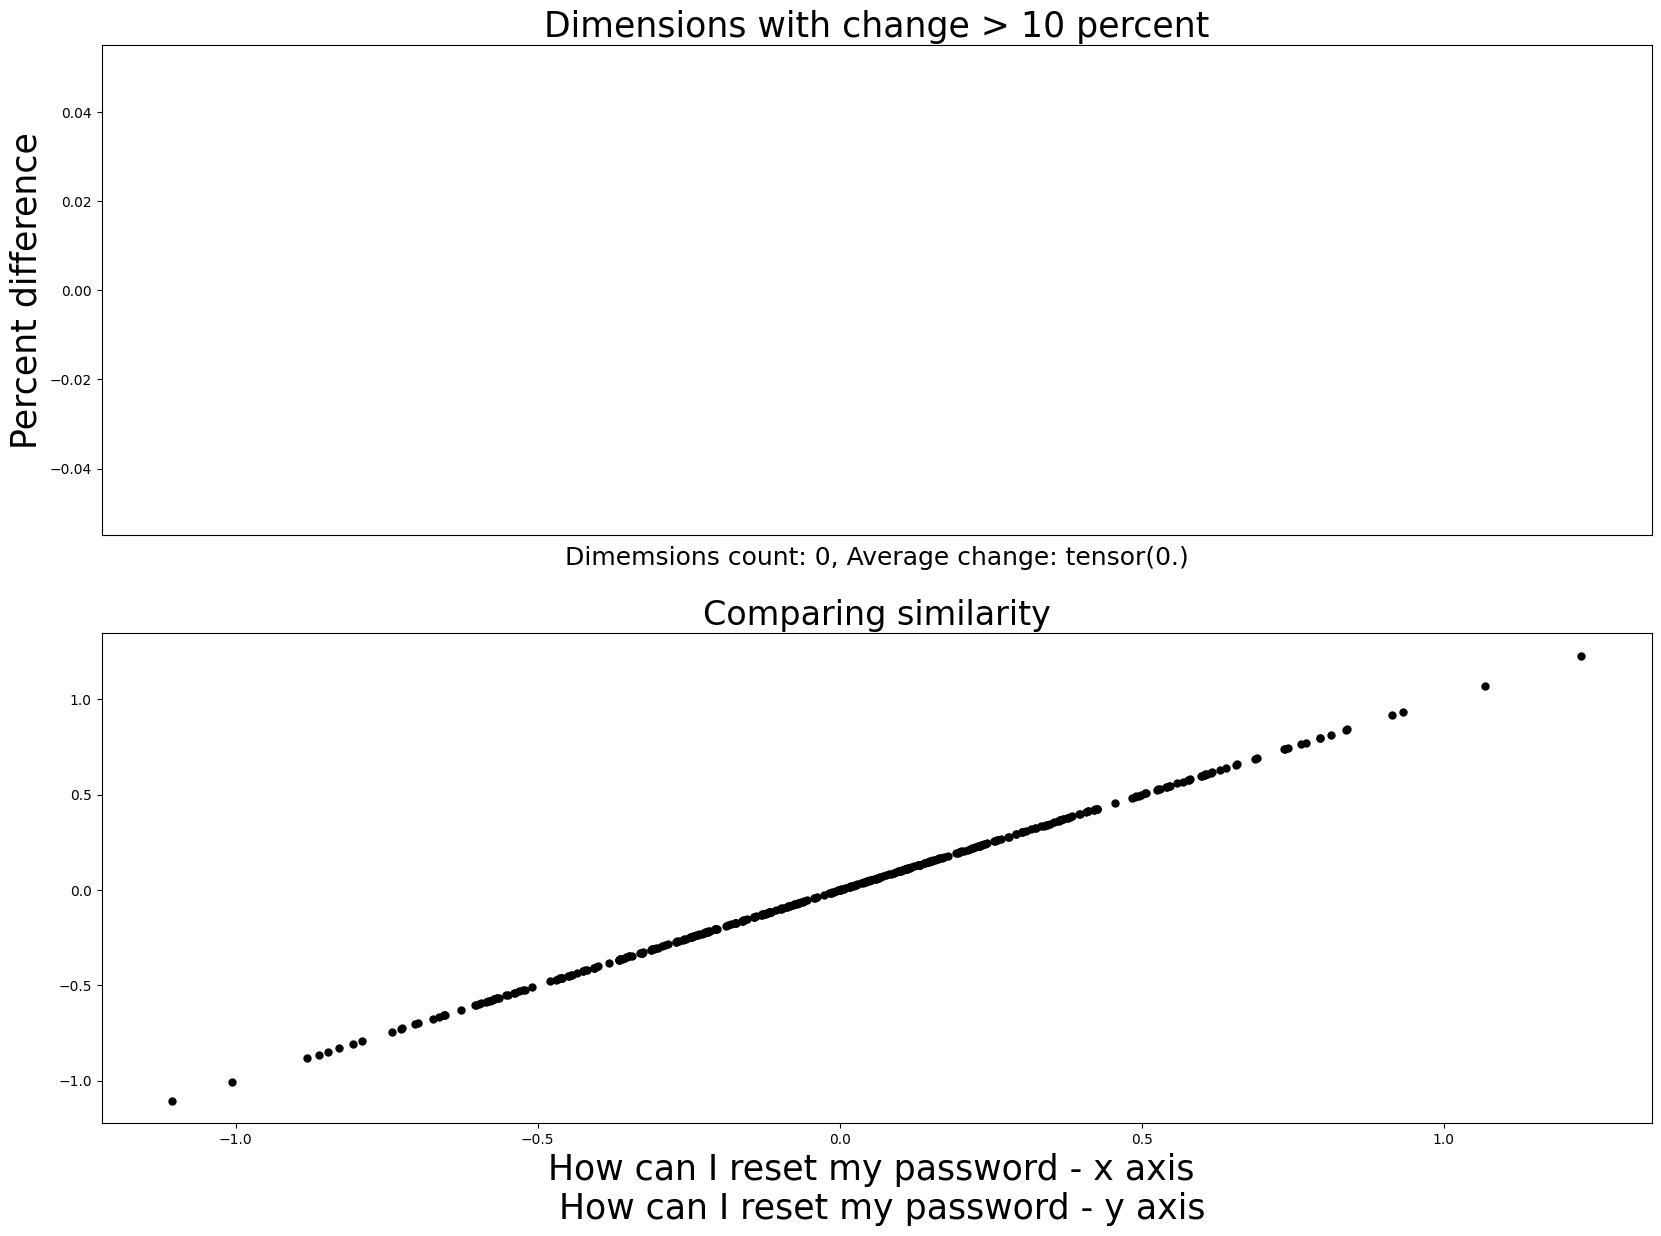

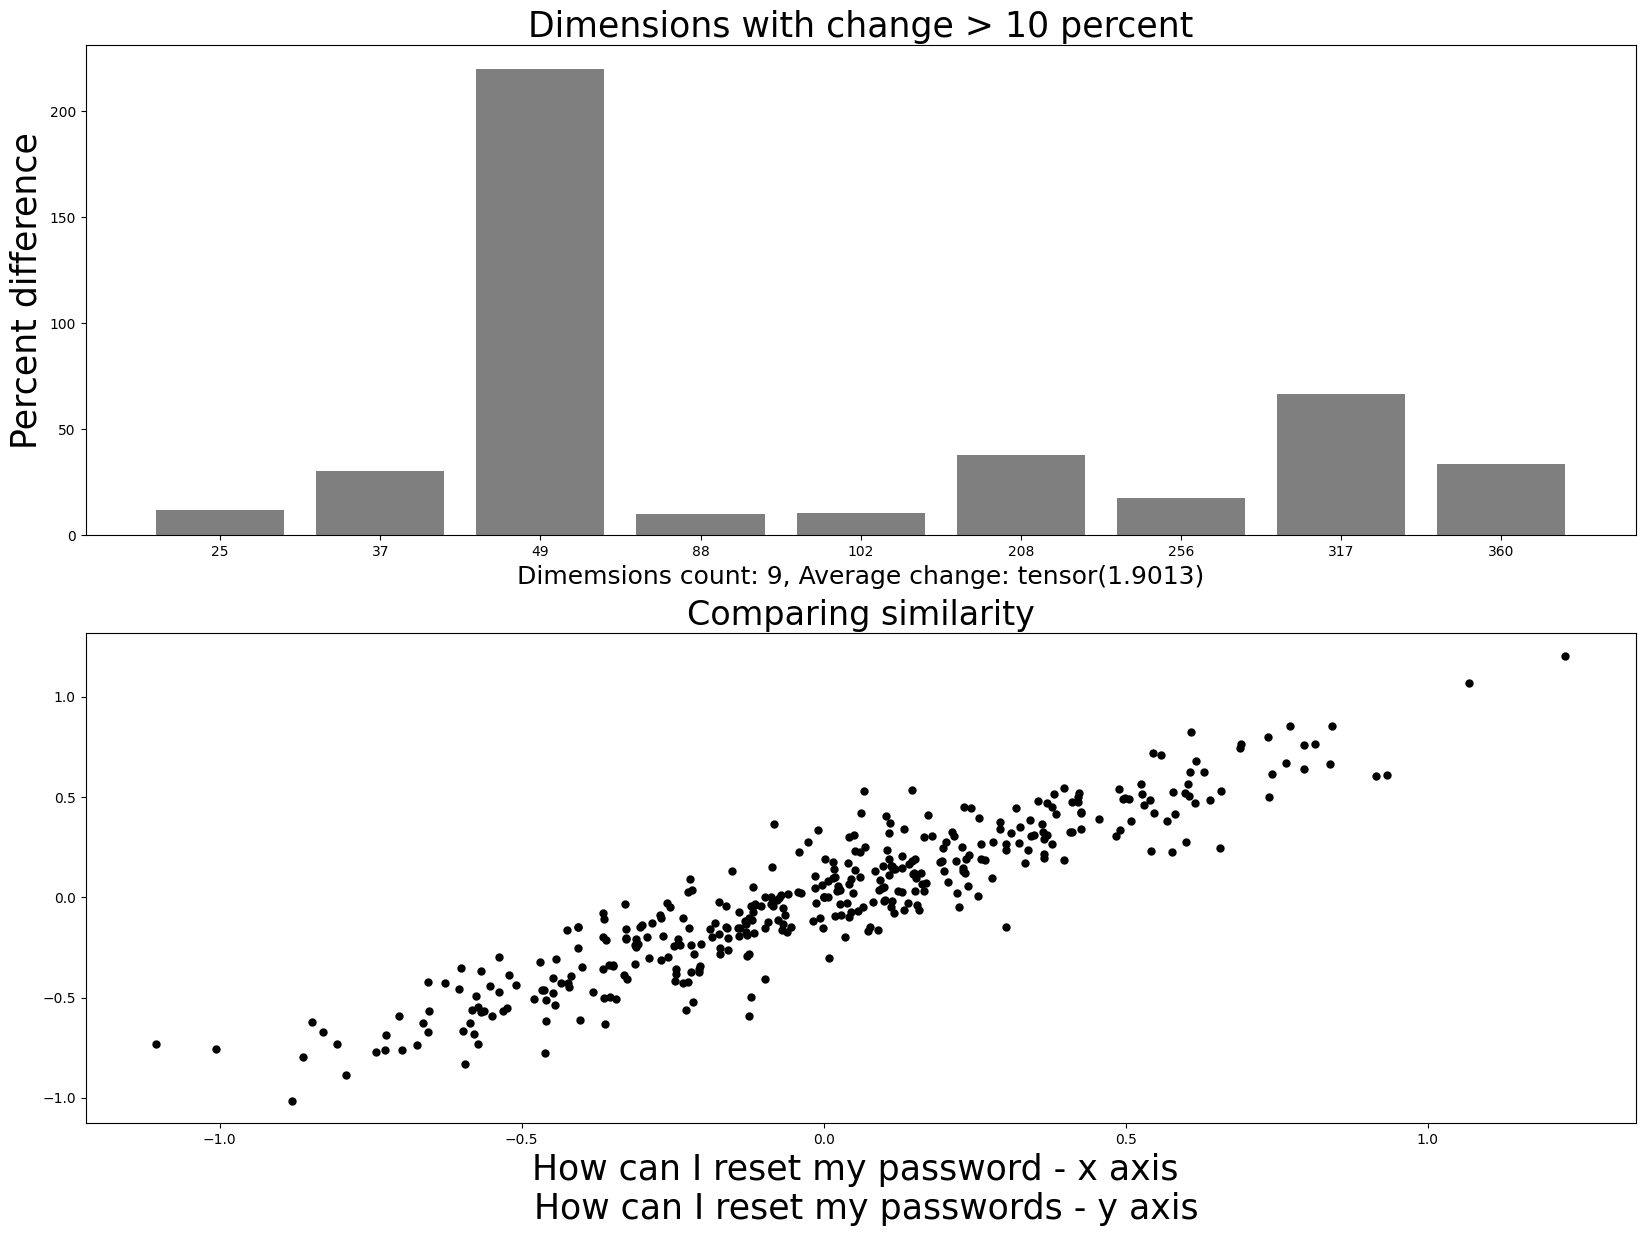

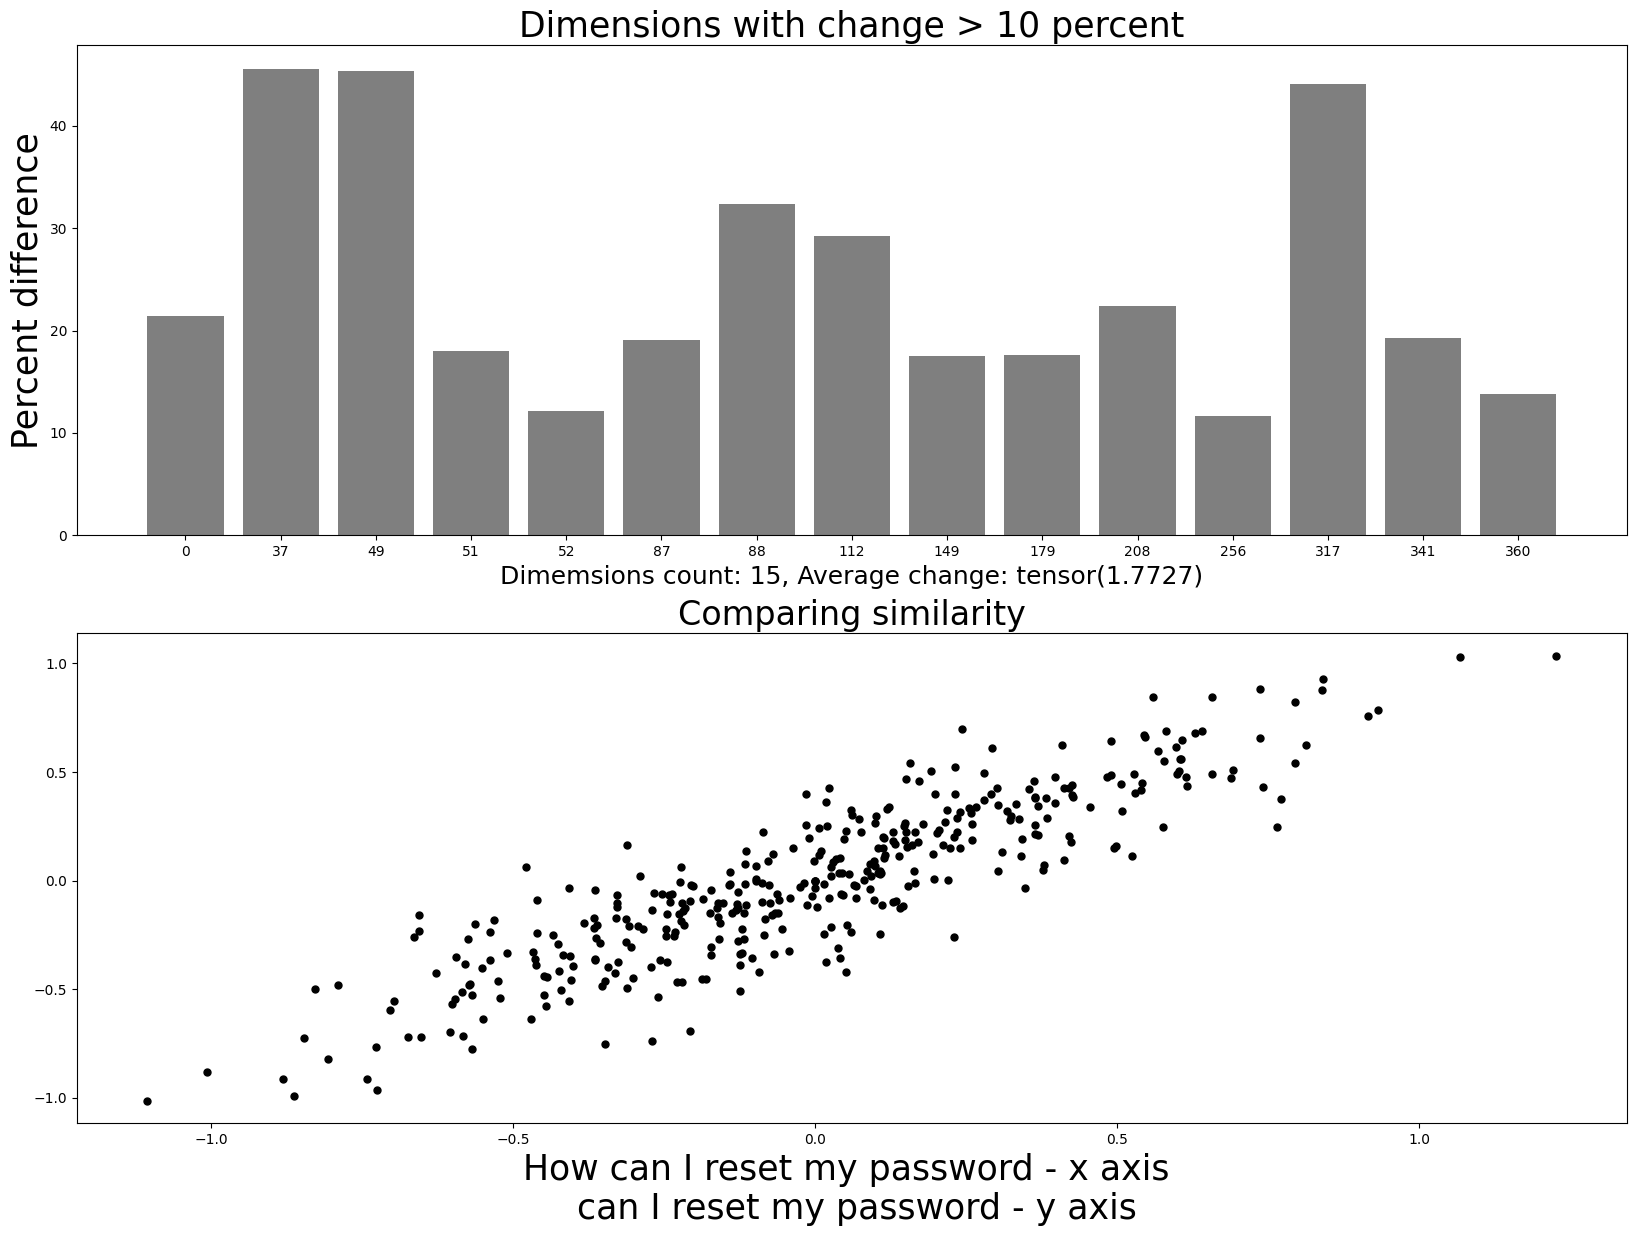

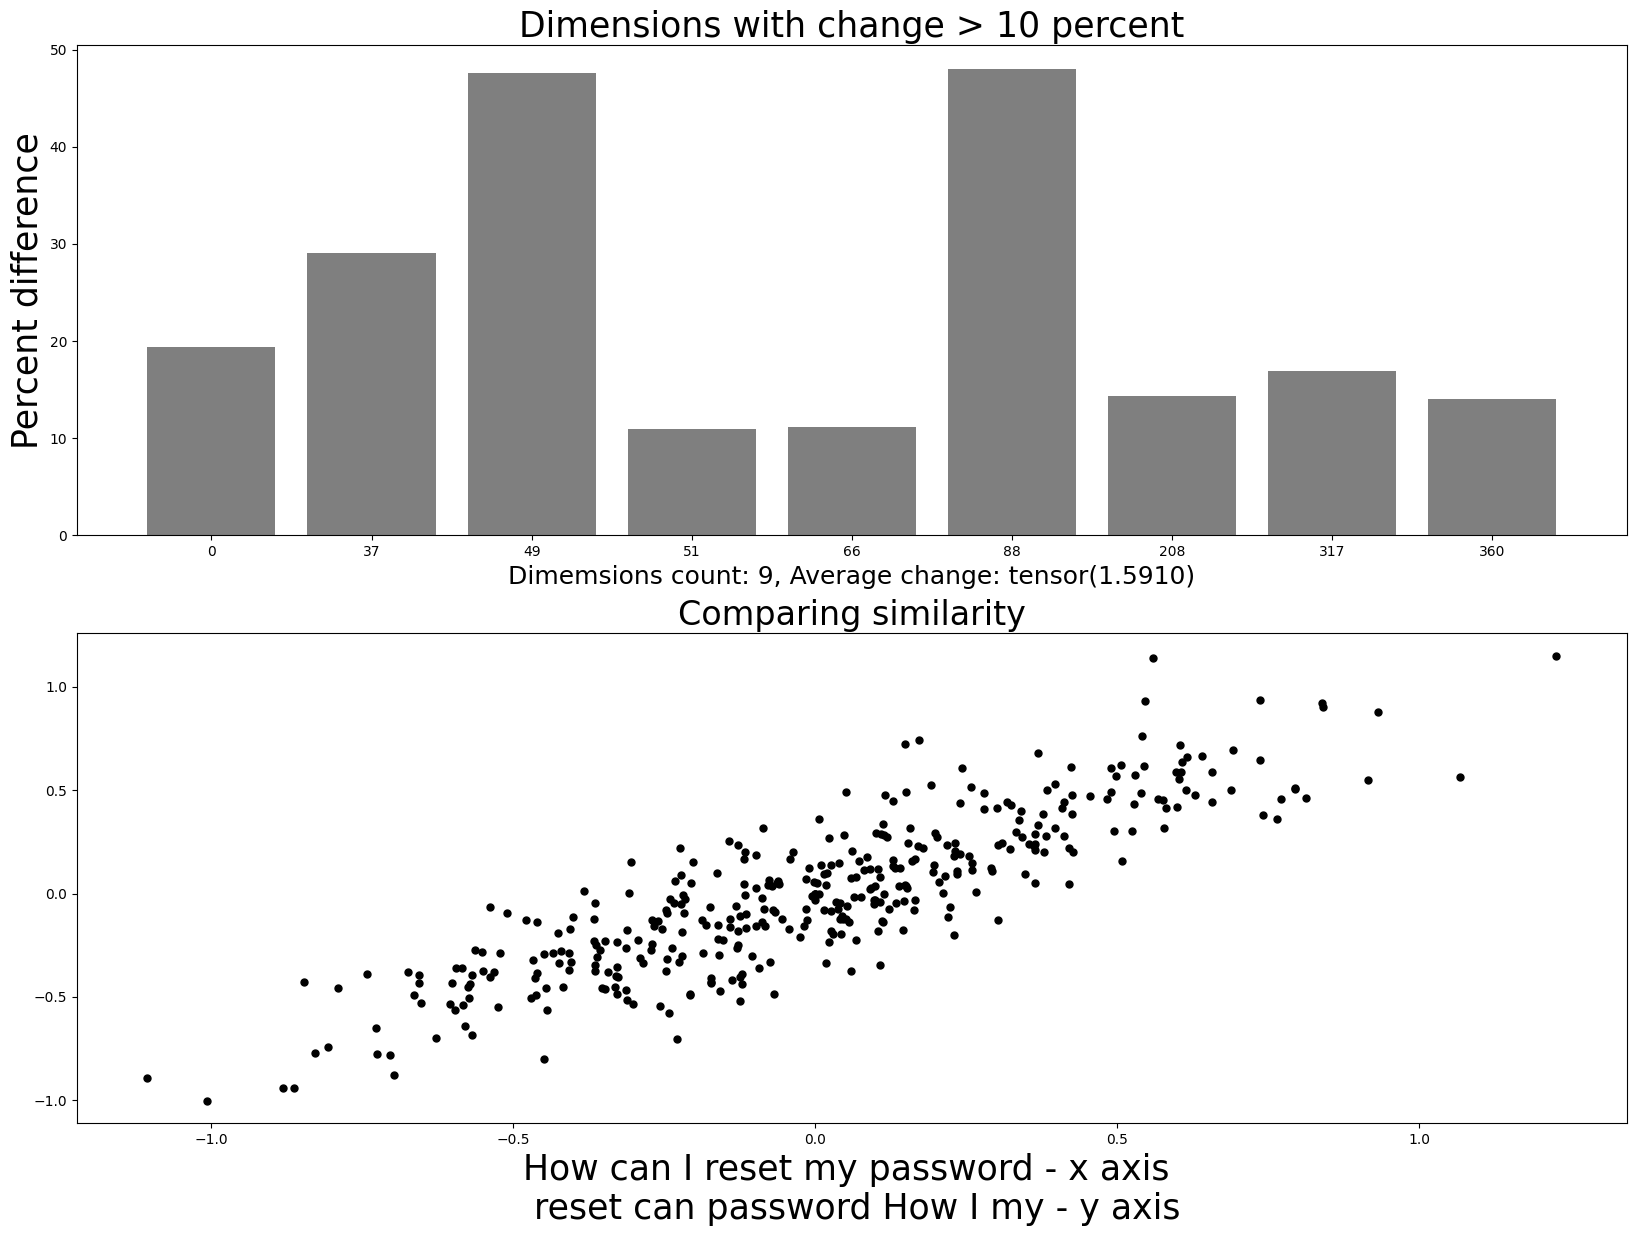

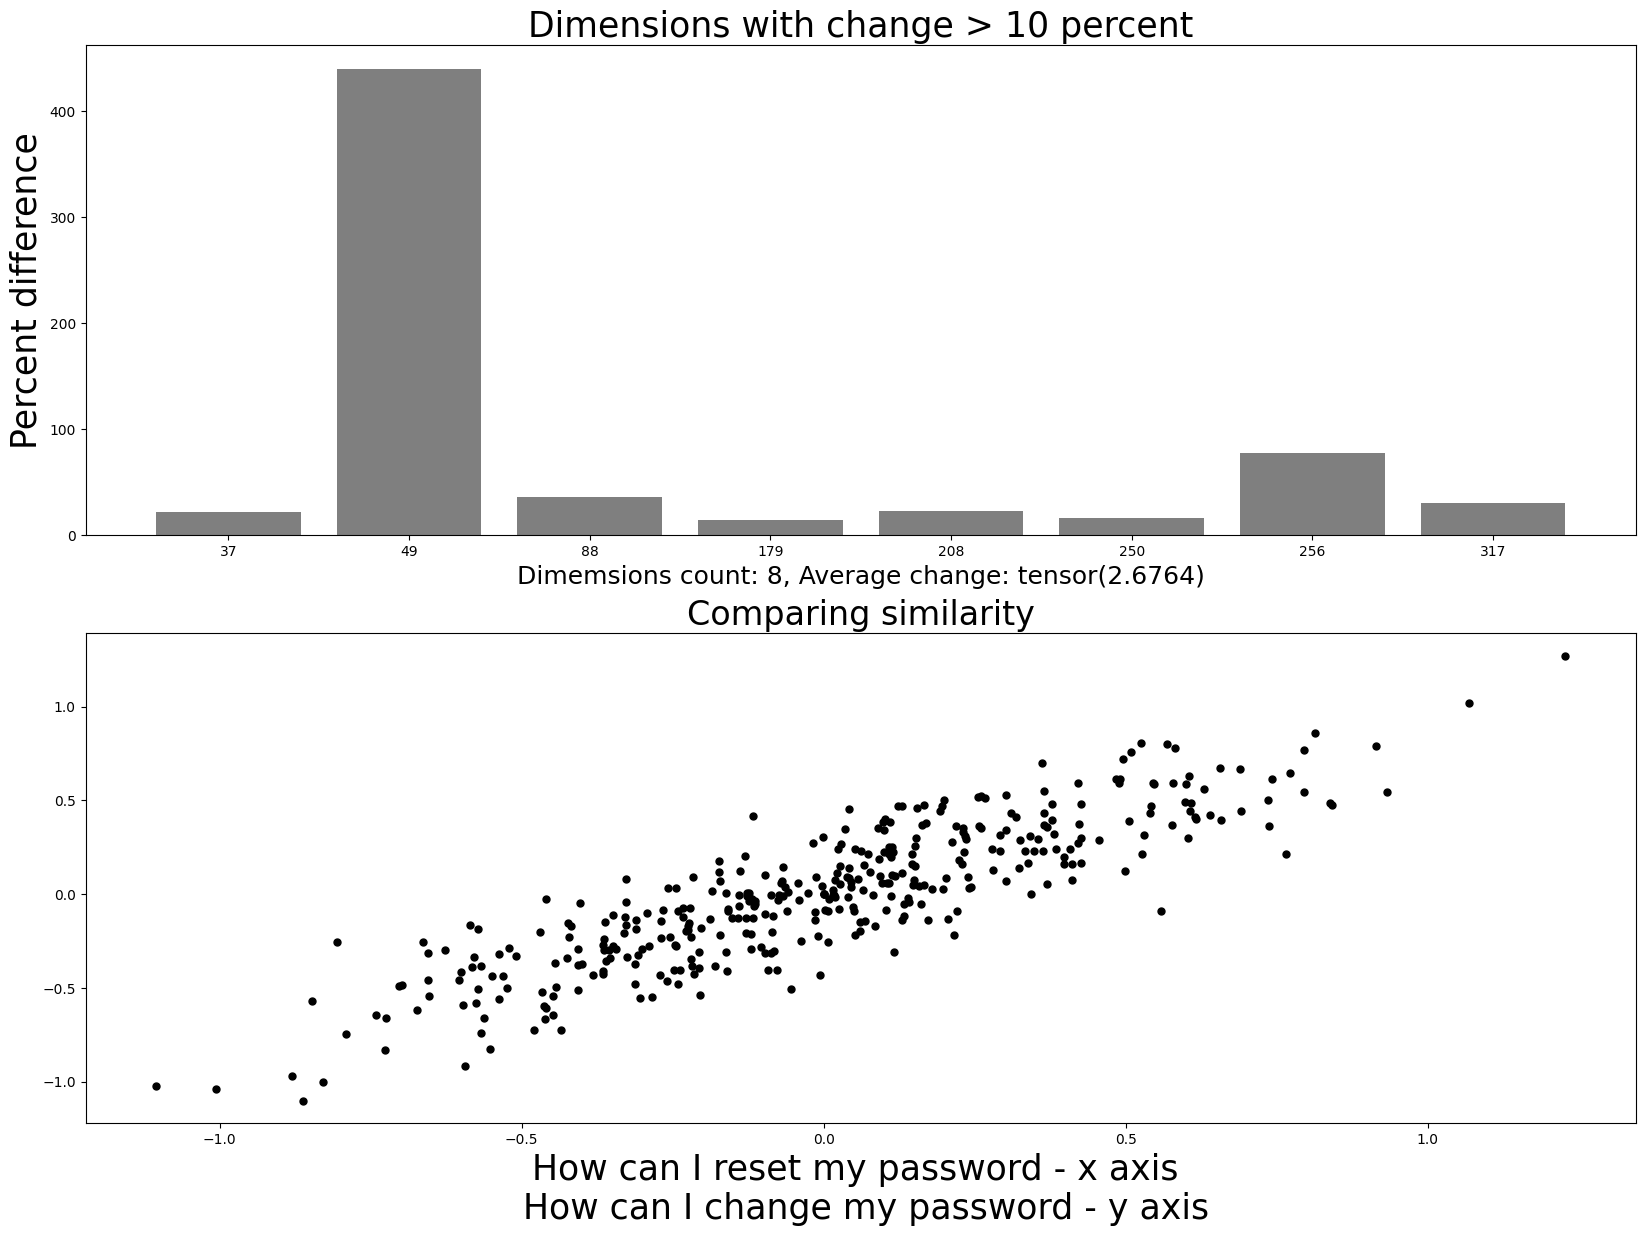

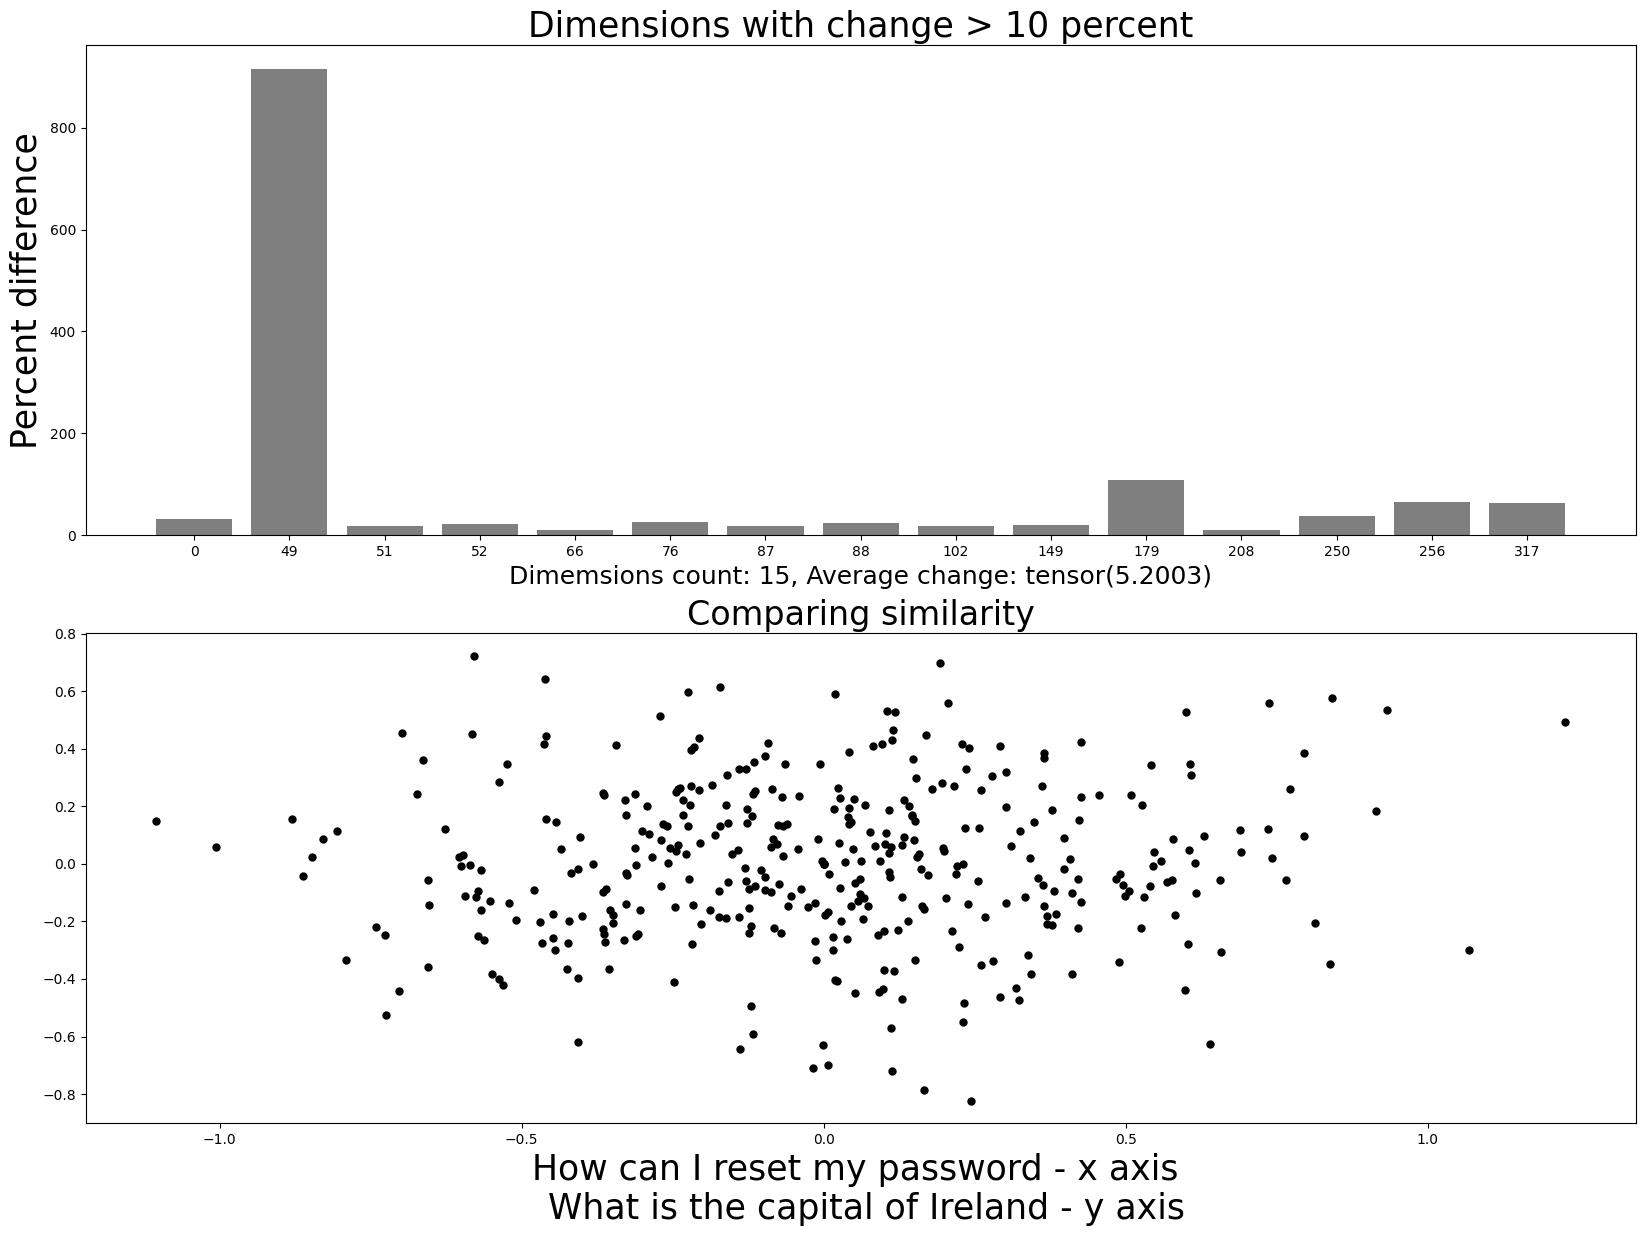

In [46]:
# Replace these examples with your own sentences
sentences = [
    ["How can I reset my password", "How can I reset my password"],
    ["How can I reset my password", "How can I reset my passwords"],
    ["How can I reset my password", "can I reset my password"],
    ["How can I reset my password", "reset can password How I my"],
    ["How can I reset my password", "How can I change my password"],
    ["How can I reset my password", "What is the capital of Ireland"],
            ]

for sentence in sentences:
    embeds = generate_embedding(sentence)
    diffs = calc_diff(embeds)
    charts(diffs, embeds, sentence)

If we create a scatterplot of any two embeddings, we can see if there is a correlation between the dimensions. For example, if we generate a random distribution, we would expect to see a spherically dispersed arrangement of points. Conversely, if the dimensions correlate completely, then it should be a straight line like we would find in a linear regression example.  

We are now comparing the sentences “How can I reset my password” with “What is the capital of Ireland”. We can clearly see the difference with our diagrams. The average difference between dimensions is 5.2. We can see a number of dimensions changed by over 10% which makes sense as they are difference sentences.

What is interesting in the dimension bar chart is that one dimensions, number 49, changed by much more than the others.

Does this represent a dimension which grades overall similarity? Or measures word comparison? Or does it identify sentence categories?
We can theorize what it means, but it clearly seems to be a stronger signal indicator that any of the other dimensions. The scatterplot also indicates a random spherical dispersion which seems correct as the sentences are completely unrelated. This seems to verify that there is some merit to our chosen methods to represent these sentences.

So what have we learned from visually inspecting our model output?
Sentence embedding definitely warrants more investigation.

They capture semantic similarity and also ordering. We can see clear differences between identical sentences and completely unrelated sentences. We cannot identify a clear pattern of change in the dimensions that differ between examples. There seem to be a small number of dimensions that change in each example. This would seem to indicate that most of the information is being carried by only a few dimensions.

But we need to be careful not to draw too many conclusions from our brief investigation. The example sentences were carefully selected and do not really test how well sentence embeddings would perform in a real scenario.

### Cosine Similarity

Remember that our embeddings are vectors, so we can use this fact to evaluate how similar they are to each other. Cosine similarity is a common way to measure similarity by getting the cosine of the angle between our two vectors, which in this case represent our sentences. 

In [48]:
# For evaluation we use exactly normalized rather than
# approximately normalized.
def normalize_embeddings(sentences):
    sentence_embeddings = generate_embedding(sentences)
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim =1)
    return sentence_embeddings

In [57]:
sentences = ['How can I reset my password?', 'What is the capital of Ireland?']
test_sentence_embeddings = normalize_embeddings(sentences)

In [58]:
from scipy.spatial import distance
distance.cosine(test_sentence_embeddings[0], test_sentence_embeddings[1])

0.9429526068270206